In [1]:
from __future__ import unicode_literals, print_function , division
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [5]:
import unicodedata
import string
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)

Slusarski


In [6]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
# Tuning Names into Tensors
import torch
def letterToIndex(letter):
    return all_letters.find(letter)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [8]:
# Creating the Network
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8673, -2.8735, -2.8774, -2.8612, -2.9661, -2.7859, -2.8758, -2.8475,
         -2.8863, -2.8463, -2.8909, -2.9252, -2.8820, -2.9693, -3.0213, -2.7877,
         -2.9487, -2.9462]], grad_fn=<LogSoftmaxBackward>)


In [10]:
# Training
# Preparing for Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 5)


In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Pasternak
category = Dutch / line = Middelburg
category = Korean / line = Gil
category = German / line = Bruhn
category = Russian / line = Chuvstvin
category = Arabic / line = Bazzi
category = Chinese / line = Xing
category = Portuguese / line = Cabral
category = Vietnamese / line = Hoang
category = Dutch / line = Rompaey


In [17]:
# training the network
criterion = nn.NLLLoss()
learning_rate = 0.005
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.9163 Rios / Vietnamese ✗ (Portuguese)
10000 10% (0m 11s) 2.6476 Almeida / Italian ✗ (Portuguese)
15000 15% (0m 16s) 1.5955 Houten / Dutch ✓
20000 20% (0m 22s) 3.1705 Adam / Arabic ✗ (German)
25000 25% (0m 27s) 1.1052 Shadid / Arabic ✓
30000 30% (0m 32s) 2.5587 Chmiel / Arabic ✗ (Polish)
35000 35% (0m 38s) 3.2105 Alexander / French ✗ (Scottish)
40000 40% (0m 43s) 0.0940 Gianakopulos / Greek ✓
45000 45% (0m 48s) 1.0279 Castro / Portuguese ✓
50000 50% (0m 53s) 2.1065 Albrecht / French ✗ (German)
55000 55% (0m 58s) 3.2806 Aonghus / Arabic ✗ (Irish)
60000 60% (1m 3s) 0.1562 Tikhonenko / Russian ✓
65000 65% (1m 8s) 0.2218 Yan / Chinese ✓
70000 70% (1m 13s) 1.1699 Krauss / German ✓
75000 75% (1m 19s) 2.1123 Schneider / Dutch ✗ (Czech)
80000 80% (1m 24s) 0.2884 Khouri / Arabic ✓
85000 85% (1m 29s) 1.8072 Matsushina / Czech ✗ (Japanese)
90000 90% (1m 34s) 0.8238 Herbert / French ✓
95000 95% (1m 39s) 2.1247 Stepan / English ✗ (Czech)
100000 100% (1m 44s) 0.1564 Donnchadh / Iris

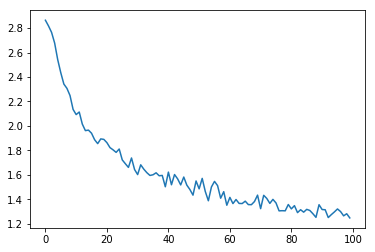

In [20]:
# Plotting the Results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

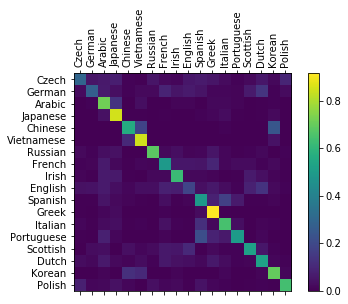

In [21]:
# Evaluating the Results
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [24]:
# Running on User Input
def predict(input_line, n_prediction=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        # Get top N categories
        topv, topi = output.topk(n_prediction, 1, True)
        predictions = []
        for i in range(n_prediction):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.60) Russian
(-1.08) Czech
(-3.20) Greek

> Jackson
(-0.85) English
(-1.52) Scottish
(-1.81) Dutch

> Satoshi
(-0.58) Japanese
(-1.88) Arabic
(-1.95) Italian


In [26]:
predict('Seiya')


> Seiya
(-0.28) Japanese
(-3.00) Portuguese
(-3.06) Czech


In [27]:
predict('Adam')


> Adam
(-1.18) Arabic
(-1.23) Irish
(-2.91) English


In [28]:
predict('John')


> John
(-0.47) Korean
(-2.21) Chinese
(-2.71) Vietnamese
